<a href="https://colab.research.google.com/github/dany-xu/AI-Generated-Text-Detection-using-LLM/blob/main/models/llama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # current dir: '/content'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Mounted at /content/drive


In [ ]:
# check the GPU disk info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 27 18:53:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

In [ ]:
# get model from Hugging Face
base_model = "NousResearch/Llama-2-7b-chat-hf"

In [ ]:
def setup_model(base_model: str) -> tuple:
    assert base_model, "Base model must be provided."

    compute_dtype = getattr(torch, "float16")
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        quantization_config=quant_config,
        device_map={"": 0}
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

def predict_text(model, tokenizer, input_text, max_len):
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_len, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_text = generated_text[len(input_text):].strip() # remove input sentences
    return generated_text

# Example usage
base_model = "NousResearch/Llama-2-7b-chat-hf"
model, tokenizer = setup_model(base_model)

input_text = "What are the steps to become a doctor?"
predicted_text = predict_text(model, tokenizer, input_text, 50)
print("Predicted Text:", predicted_text)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

Predicted Text: everybody wants to become a doctor, but it's not an easy task. it takes a lot of hard work, dedication, and perseverance. here are the steps to become


In [ ]:
# try an example from project dataset
input_text = "Is the following text generated by AI or from human? Give me simply yes or no. The text is \" To solve the problems of the data reliability for NAND flash storages, a variable-node-based belief-propagation with message pre-processing (VNBP-MP) decoding algorithm for binary low-density parity-check (LDPC) codes is proposed. The major feature is that, by making use of the characteristics of the NAND flash channel, the proposed algorithm performs the message pre-processing (MP) scheme to effectively prevent the propagation of unreliable messages and speed up the propagation of reliable messages. Additionally, the VNBP-MP algorithm includes a treatment for oscillating variable nodes (VNs) to further accelerate decoding convergence. Simulation results show that the proposed VNBP-MP algorithm has a noticeable improvement in convergence speed without compromising the error-correction performance, compared with the existing algorithms.\""
pred_text = predict_text(model, tokenizer, input_text, 300)
print("Predicted Text:", pred_text)

Predicted Text: Yes


'\nfor example in dataset:\n    question = example["text"]\n    true_answer = example["label"]  # Assuming the label contains the true answer\n    # Generate predicted answer\n    predicted_answer = generate_prediction(question) \n    # Compare predicted answer with true answer\n    print("Question:", question)\n    print("True Answer:", true_answer)\n    print("Predicted Answer:", predicted_answer)\n    print("------------------------------------------------------")\n'

In [ ]:
type(predicted_text), len(predicted_text)

(str, 3)

max len for abstract:  3868


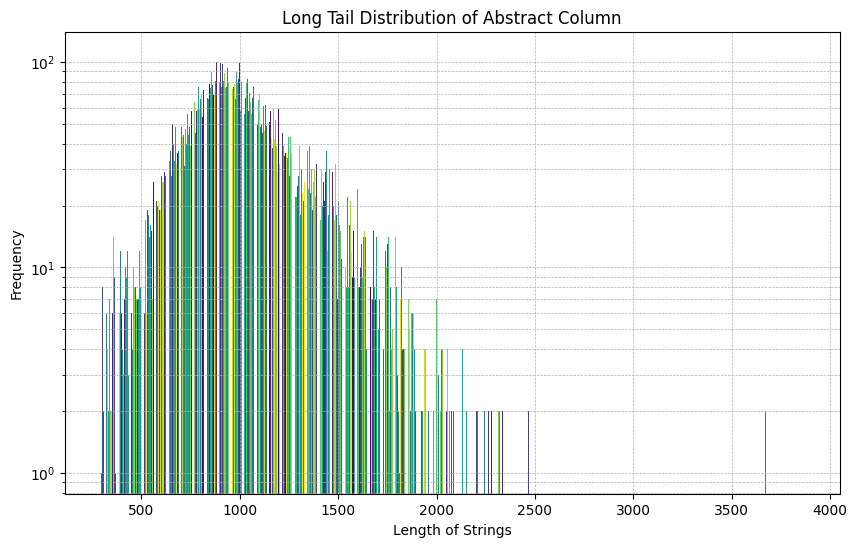

In [ ]:
data = pd.read_csv("./drive/MyDrive/ColabNotebooks/llm/concat_ori.csv").drop(columns=["Unnamed: 0"])
max_len = data["abstract"].apply(len).max()
print("max len for abstract: ", max_len)

lengths = data["abstract"].apply(len)

color = sns.color_palette("viridis", 50)
length_counts = lengths.value_counts()
sorted_lengths = length_counts.index
sorted_counts = length_counts.values

plt.figure(figsize=(10, 6))
plt.bar(sorted_lengths, sorted_counts, color=color, linewidth=0.5)
plt.title("Long Tail Distribution of Abstract Column")
plt.xlabel("Length of Strings")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
# generate through whole dataset
data1 = data[data['label'] == 1]
data0 = data[data['label'] == 0]
train1, test1 = train_test_split(data1, test_size=0.2)
train0, test0 = train_test_split(data0, test_size=0.2)
train = pd.concat([train0, train1], ignore_index=True)
test = pd.concat([test0, test1], ignore_index=True)
train = random.shuffle (train)
test = random.shuffle (test)

def answer_align(pred_answer): # get accurate answer
    predicted_answer = pred_answer.lower()
    if "yes" in predicted_answer:
        return "1"
    elif "no" in predicted_answer:
        return "0"
    else:
        return "2"

result = []
dataset = [] # make data compatible with model training

for idx, d in test.iterrows():
    question = "Is the following text generated by AI or from human? Give me simply yes or no." + d[3] # abstract
    pred_answer = predict_text(model, tokenizer, question, len(question))
    print(idx, answer_align(pred_answer), pred_answer)
    result.append({"abstract": d[3], "true_label": d[4], "pred_label": answer_align(pred_answer)}) # abstract, label
    dataset.append({"text": question, "label": d[4]})

result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling f

0 Yes
1 Yes
2 Yes
3 Yes
4 Yes
5 Yes, the text was generated by AI.
6 Yes
7 Yes
8 The results show that the deep learning approach can accurately identify the noise jamming factor of the receiver, and the identification accuracy is higher than that of the traditional method.

Yes
9 Yes
10 Yes
11 Yes, the text was generated by AI.
12 (100 words)

Yes
13 
14 Yes
15 Yes, the text is generated by AI.
16 Yes
17 Yes
18 Yes, the text is generated by AI.
19 Yes, the text was generated by AI.
20 Yes, the text is generated by AI.
21 Yes
22 Yes
23 Yes
24 (100 words)

Yes
25 Yes
26 The results show that the transmission success probability increases with the SINR threshold, and the optimal SINR threshold for maximum transmission success probability is determined.

Yes
27 Yes
28 Yes
29 Yes
30 Yes
31 Yes
32 Yes
33 Yes
34 
35 Yes
36 Yes
37 Yes
38 
39 Yes
40 Yes
41 Yes
42 Yes, the text was generated by AI.
43 Yes
44 Yes, the text was generated by AI.
45 Yes
46 Yes
47 Yes
48 Yes
49 Yes
50 Yes
51 Yes
52 

In [ ]:
# measure results
true_labels = result['true_label'].tolist()
pred_labels = result['pred_label'].tolist()
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
conf_matrix = confusion_matrix(true_labels, pred_labels) # confusion matrix

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:", conf_matrix)
print("Among above, unrecognized sample numbers: ", (result['pred_label'] == 2).sum())

result.to_csv("./drive/MyDrive/ColabNotebooks/llm/llama_test_result.csv")

### below is how to fintune llama-7B but did not work out according to insufficient GPU.

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
training_params = TrainingArguments(
    output_dir="./drive/MyDrive/ColabNotebooks/llm/llama/results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 35.06 MiB is free. Process 1892 has 14.71 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 364.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)